In [4]:
#Setup environment and load data 
import re
import gdown
import seaborn as sns
import pandas as pd
import numpy as np
from torchtext.vocab import GloVe
from sklearn.model_selection import train_test_split
gdown.download('https://drive.google.com/uc?id=1umFXM7SvdBvTlHW0r0CXDcxNqL73jU8Z', 'disaster_data.csv', True)
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
import requests, io, zipfile

In [5]:
# Load the data.
disaster_tweets = pd.read_csv('disaster_data.csv',encoding ="ISO-8859-1")

In [6]:
disaster_tweets.head()

,tweet_id,text,category,need_or_resource
0,ca9e24c8-396d-4502-8b45-18895df5333e_0,"Donations of batteries, flashlights, and clean...",Energy,need
1,twitter_resource_tweets_1692,I want hurricane Sandy to cone so I can be stu...,None,NaN
2,625b46e2-0b81-41ea-826e-4535fe9b39b8,"Hi, I can help prepare food, serve food, offer...",Food,resource
3,twitter_resource_tweets_1699,I cant believe Sandy.....,None,NaN
4,c3bfea72-d377-445c-b4b8-e8ebca0e7fbb,I have children and adult clothes including ja...,Water,resource


In [7]:
#Read the tweet data and convert it to lowercase
tweets = disaster_tweets['text'].str.lower() 
tweets = tweets.apply(lambda x: re.sub(r'[^a-zA-Z0-9]+', ' ',x))

In [8]:
#Extract the labels from the csv
tweet_labels = disaster_tweets['category']

In [9]:
#Split the Data into Training and Testing
X_train, X_test, y_train, y_test = train_test_split(tweets, tweet_labels, test_size=0.2, random_state=1,stratify = tweet_labels)

In [10]:
VEC_SIZE = 300
glove = GloVe(name='6B', dim=VEC_SIZE)

# Returns word vector for word if it exists, else return None.
def get_word_vector(word):
    try:
      return glove.vectors[glove.stoi[word.lower()]].numpy()
    except KeyError:
      return None

.vector_cache/glove.6B.zip: 862MB [06:30, 2.21MB/s]                           
100%|█████████▉| 399599/400000 [00:45<00:00, 8641.23it/s]

In [11]:
good_vector = get_word_vector('good')

print('Shape of good vector:', good_vector.shape)
print(good_vector)

Shape of good vector: (300,)
[-1.3602e-01 -1.1594e-01 -1.7078e-02 -2.9256e-01  1.6149e-02  8.6472e-02
  1.5759e-03  3.4395e-01  2.1661e-01 -2.1366e+00  3.5278e-01 -2.3909e-01
 -2.2174e-01  3.6413e-01 -4.5021e-01  1.2104e-01 -1.5596e-01 -3.8906e-02
 -2.9419e-03  1.6009e-02 -1.1620e-01  3.8680e-01  3.5109e-01  9.7426e-02
 -1.2425e-02 -1.7864e-01 -2.3259e-01 -2.6960e-01  4.1083e-02 -7.6194e-02
 -2.3362e-01  2.0919e-01 -2.7264e-01  5.4967e-02 -1.8055e+00  5.6348e-01
 -1.2778e-01  2.3147e-01 -5.8820e-03 -2.6630e-01  4.1187e-01 -3.7162e-01
 -2.0600e-01 -1.9619e-01 -4.3945e-03  1.2513e-01  4.6638e-01  4.5159e-01
 -1.5000e-01  5.9589e-03  5.9070e-02 -4.1440e-01  6.1035e-02 -2.1117e-01
 -4.0988e-01  5.6393e-01  2.3021e-01  2.7240e-01  4.9364e-02  1.4239e-01
  4.1841e-01 -1.3983e-01  3.4826e-01 -1.0745e-01 -2.5002e-01 -3.2554e-01
  3.3343e-01 -3.5617e-01  2.0442e-01  1.4439e-01 -1.2686e-01 -7.7273e-02
 -1.9667e-01  1.0759e-01 -1.1860e-01 -2.5083e-01  1.4205e-02  2.7251e-01
 -2.3707e-01 -2.3545e-

In [12]:
def cosine_similarity(vec1, vec2):    
  return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

word1 = "mumbai" #@param {type:"string"}
word2 = "delhi" #@param {type:"string"}

print('Word 1:', word1)
print('Word 2:', word2)

def cosine_similarity_of_words(word1, word2):
  vec1 = get_word_vector(word1)
  vec2 = get_word_vector(word2)
  
  if vec1 is None:
    print(word1, 'is not a valid word. Try another.')
  if vec2 is None:
    print(word2, 'is not a valid word. Try another.')
  if vec1 is None or vec2 is None:
    return None
  
  return cosine_similarity(vec1, vec2)
  

print('\nCosine similarity:', cosine_similarity_of_words(word1, word2))

Word 1: mumbai
Word 2: delhi

Cosine similarity: 0.65649796


In [15]:
def glove_transform_data_descriptions(data):
    X = np.zeros((len(data), VEC_SIZE))
    
    
    for i, tweet in enumerate(data):
        found_words = 0.0
        tweet = tweet.strip()
        for word in tweet.split():
           
            vec = get_word_vector(word)
            if vec is not None:
                
                # Increment found_words and add vec to X[i].
                found_words += 1
                X[i] += vec
                
        # We divide the sum by the number of words added, so we have the
        # average word vector.
        if found_words > 0:
            X[i] /= found_words
            
    return X
  
glove_train_X = glove_transform_data_descriptions(X_train)
glove_train_y = [label for label in y_train]
print ("Train_shape",glove_train_X.shape)
glove_test_X = glove_transform_data_descriptions(X_test)
glove_test_y = [label for label in y_test]
print ("Test shape",glove_test_X.shape)

Train_shape (1120, 300)
Test shape (281, 300)


In [16]:
model = LogisticRegression()

model.fit(glove_train_X, glove_train_y)

glove_train_y_pred = model.predict(glove_train_X)
print('Train accuracy', accuracy_score(glove_train_y, glove_train_y_pred))

glove_test_y_pred = model.predict(glove_test_X)
print('Val accuracy', accuracy_score(glove_test_y, glove_test_y_pred))

print('Confusion matrix:')
print(confusion_matrix(glove_test_y, glove_test_y_pred))

prf = precision_recall_fscore_support(glove_test_y, glove_test_y_pred)

print('Precision:', prf[0][1])
print('Recall:', prf[1][1])
print('F-Score:', prf[2][1])

Train accuracy 0.8946428571428572
Val accuracy 0.8790035587188612
Confusion matrix:
[[ 24   2   0   8   1]
 [  0 129   1   3   0]
 [  0   3   8   0   0]
 [  7   3   0  67   0]
 [  1   3   0   2  19]]
Precision: 0.9214285714285714
Recall: 0.9699248120300752
F-Score: 0.945054945054945


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [17]:
print(classification_report(y_test,glove_test_y_pred, target_names=['Energy', 'Food', 'Medical', 'None', 'Water']))

              precision    recall  f1-score   support

      Energy       0.75      0.69      0.72        35
        Food       0.92      0.97      0.95       133
     Medical       0.89      0.73      0.80        11
        None       0.84      0.87      0.85        77
       Water       0.95      0.76      0.84        25

    accuracy                           0.88       281
   macro avg       0.87      0.80      0.83       281
weighted avg       0.88      0.88      0.88       281



In [18]:
def plot_confusion_matrix(y_true,y_predicted):
  cm = metrics.confusion_matrix(y_true, y_predicted)
  print ("Plotting the Confusion Matrix")
  labels = ['Energy', 'Food', 'Medical', 'None', 'Water']
  df_cm = pd.DataFrame(cm,index =labels,columns = labels)
  fig = plt.figure()
  res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
  plt.yticks([0.5,1.5,2.5,3.5,4.5], labels,va='center')
  plt.title('Confusion Matrix - TestData')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  plt.close()

Plotting the Confusion Matrix


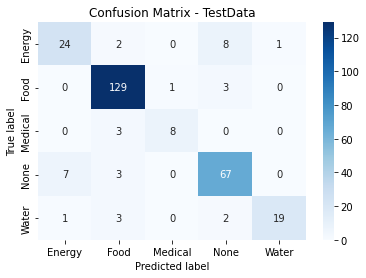

In [19]:
plot_confusion_matrix(y_test,glove_test_y_pred)

In [20]:
#List of Incorrect Tweets
pd.set_option('max_colwidth', 500)
incorrect_tweets = []
incorrect_y_test = []
incorrect_y_pred = []
for (t,x,y) in zip(X_test,y_test,glove_test_y_pred):
  if x != y:
    incorrect_tweets.append(t)
    incorrect_y_test.append(x)
    incorrect_y_pred.append(y)

In [21]:
table=pd.DataFrame([incorrect_tweets,incorrect_y_pred,incorrect_y_test]).transpose()
table.columns = ['Tweet', 'Predicted Category', 'True Category']

In [22]:
table

,Tweet,Predicted Category,True Category
0,senior nursing students we graduate this december and we want to help we can give basic medical care hand out blankets you name it we will do it thanks,Food,Medical
1,a few friends and i are happy to distribute meds,Food,Medical
2,eating cold chinese food with a flash light sandyprobs,None,Energy
3,hello there i have two trucks worth of goods water supplies clothes everything please email me at,Food,Water
4,i need groceries not because of the storm just legit need groceries,None,Food
5,sandy is so angry power is down wind over 90 mph,None,Energy
6,over 25 people in line at starbucks people need coffee as much as they need food and gas post sandy starbucks http t co t7g3fbjg,Food,None
7,i can bring batteries toiletries non perishable items hygiene products towels,Food,Energy
8,my powers out no xbox today hurricane sandy,None,Energy
9,i have a few baby supplies diapers formula blankets to give as well as water and some feminine hygiene products,Food,Water


In [25]:
#Helper Function to visualize the embeddings
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE

import re
import matplotlib.pyplot as plt

def clean(text):
    """Remove posting header, split by sentences and words, keep only letters"""
    lines = re.split('[?!.:]\s', re.sub('^.*Lines: \d+', '', re.sub('\n', ' ', text)))
    return [re.sub('[^a-zA-Z]', ' ', line).lower().split() for line in lines]

sentences = [line for text in tweets for line in clean(text)]

#min-count variable helps us eliminate the words which rarely occur! 
model = Word2Vec(sentences, workers=4, size=100, min_count=30, window=10, sample=1e-3)


def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


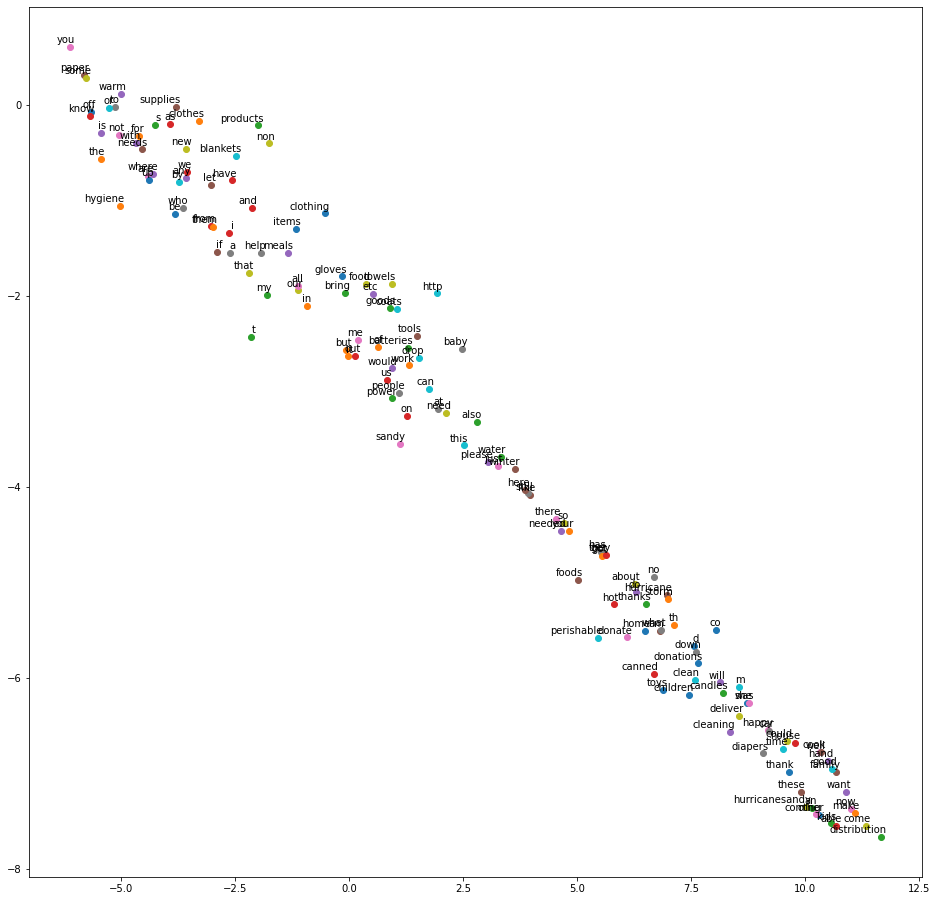

In [26]:
tsne_plot(model)